In [19]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [20]:
data = pd.read_csv('./data/trn_df_final.csv')

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

In [21]:
data.head(5)

,index,pkl_id,mileage,label,milecls,volt_tnse0,volt_tnse1,current_tnse0,current_tnse1,soc_tnse0,...,current_outliers,soc_outliers,max_single_volt_outliers,min_single_volt_outliers,max_temp_outliers,min_temp_outliers,ts_interval_outliers,patv_outliers,data_type_y.3,soc_current_min_temp
0,0,0,2445.3,0.0,1,-27.710170,7.183321,-0.780057,-72.946540,-7.409594,...,1,0,0,0,0,0,45,1,0,-5.450443
1,256,1,7644.3,0.0,2,26.238129,27.191042,4.483714,-58.018780,15.942628,...,13,0,0,0,0,0,0,11,0,-1.339517
2,512,2,4271.6,0.0,1,6.527212,-24.940310,-8.321565,51.972263,-18.387276,...,0,0,0,0,0,0,47,0,0,-2.575596
3,768,3,4990.4,0.0,1,39.042698,63.970062,14.205688,44.174520,46.051250,...,23,67,0,0,0,0,51,23,0,-1.298423
4,1024,4,4458.8,0.0,1,0.497313,-83.700860,18.397985,23.562110,75.355220,...,0,63,0,0,0,9,56,0,0,-1.061483


In [22]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features 
    # train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # ['patv','temp_range','single_volt_range','volt_ts_interval','current_ts_interval','soc_ts_interval']
    del_feat = ['pkl_id','label','index']
    
    train_features = [f for f in data if f not in del_feat]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['label'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['label'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 20,
        'verbose': -1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [23]:
# # Seed the unexpected randomness of this world
# np.random.seed(123)
# # Get the actual importance, i.e. without shuffling
# actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [24]:
actual_imp_df = pd.DataFrame()
nb_runs = 10
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    actual_imp_df_i = get_feature_importances(data=data, shuffle=False)
    actual_imp_df_i['run'] = i + 1 
    # Concat the latest importances with the old ones
    actual_imp_df = pd.concat([actual_imp_df_i, actual_imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   10 of   10 (Spent   0.1 min)

In [25]:
actual_imp_df.head(10)

,feature,importance_gain,importance_split,trn_score,run
0,mileage,749367.161608,2031,0.999512,10
1,milecls,220260.258086,200,0.999512,10
2,volt_tnse0,4304.725359,983,0.999512,10
3,volt_tnse1,4924.455278,390,0.999512,10
4,current_tnse0,24741.440228,490,0.999512,10
5,current_tnse1,55062.107314,509,0.999512,10
6,soc_tnse0,2258.905675,165,0.999512,10
7,soc_tnse1,2969.843834,157,0.999512,10
8,max_single_volt_tnse0,3718.461997,117,0.999512,10
9,max_single_volt_tnse1,2779.218745,53,0.999512,10


In [26]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent   0.9 min)

In [27]:
null_imp_df.head(10)

,feature,importance_gain,importance_split,trn_score,run
0,mileage,1932.957773,319,0.826422,1
1,milecls,40.038940,14,0.826422,1
2,volt_tnse0,1809.975997,295,0.826422,1
3,volt_tnse1,2281.081923,308,0.826422,1
4,current_tnse0,2981.525414,382,0.826422,1
5,current_tnse1,2791.596029,358,0.826422,1
6,soc_tnse0,2201.028688,283,0.826422,1
7,soc_tnse1,2537.338050,323,0.826422,1
8,max_single_volt_tnse0,1760.958496,206,0.826422,1
9,max_single_volt_tnse1,2681.713868,303,0.826422,1


In [28]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(8, 2))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

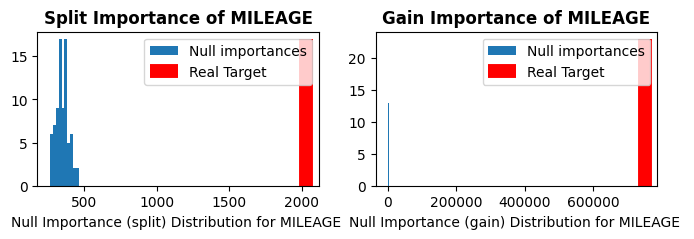

In [29]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='mileage')

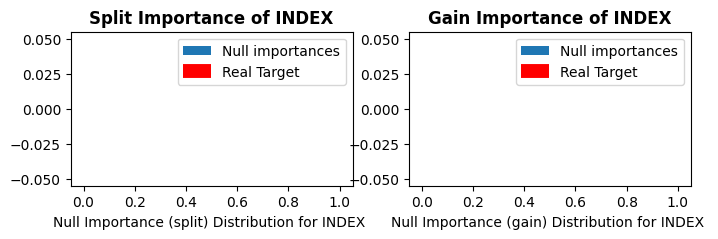

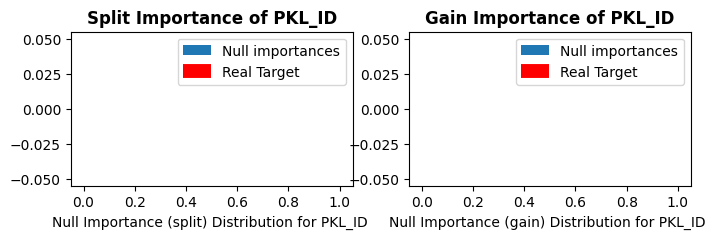

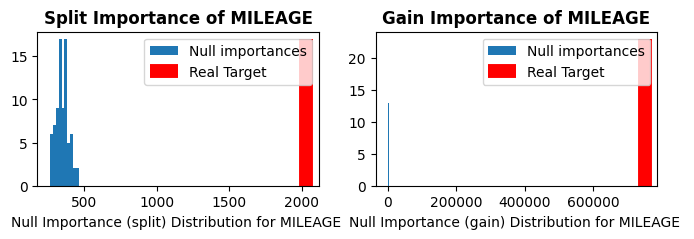

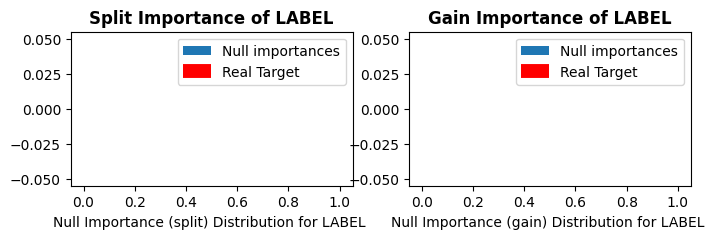

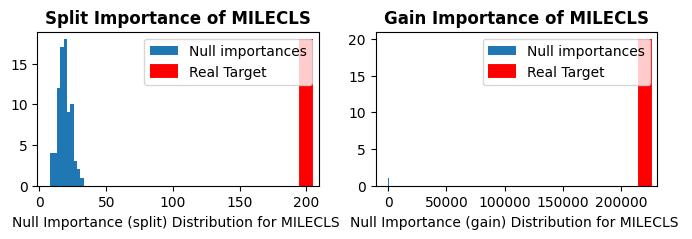

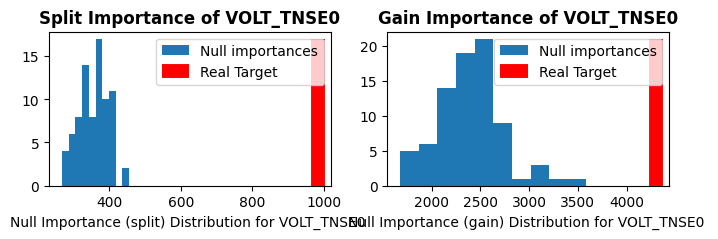

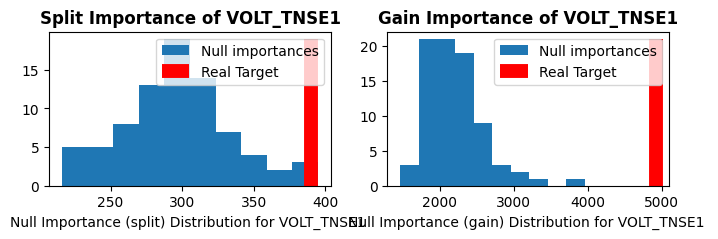

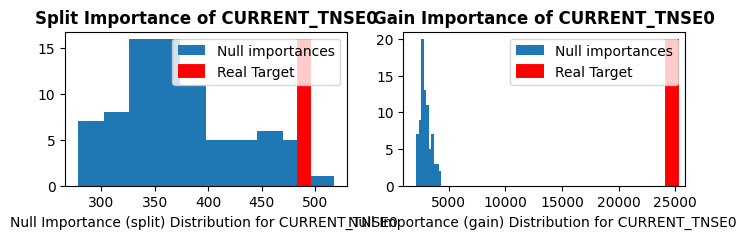

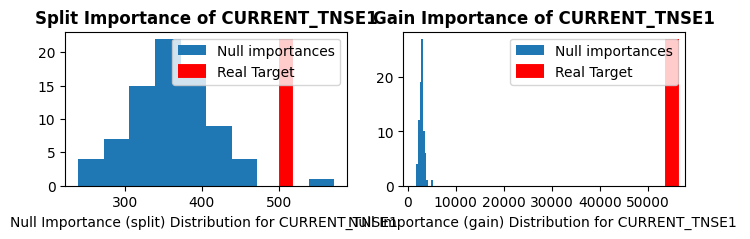

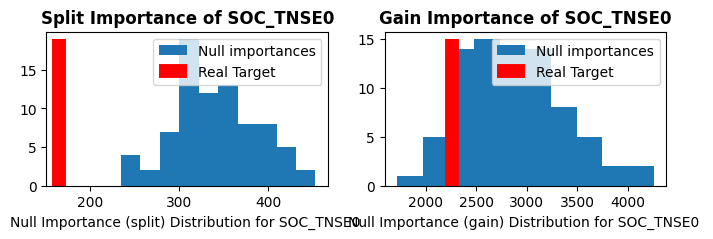

In [30]:
for feat in data.columns[:10]:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feat)
    plt.show

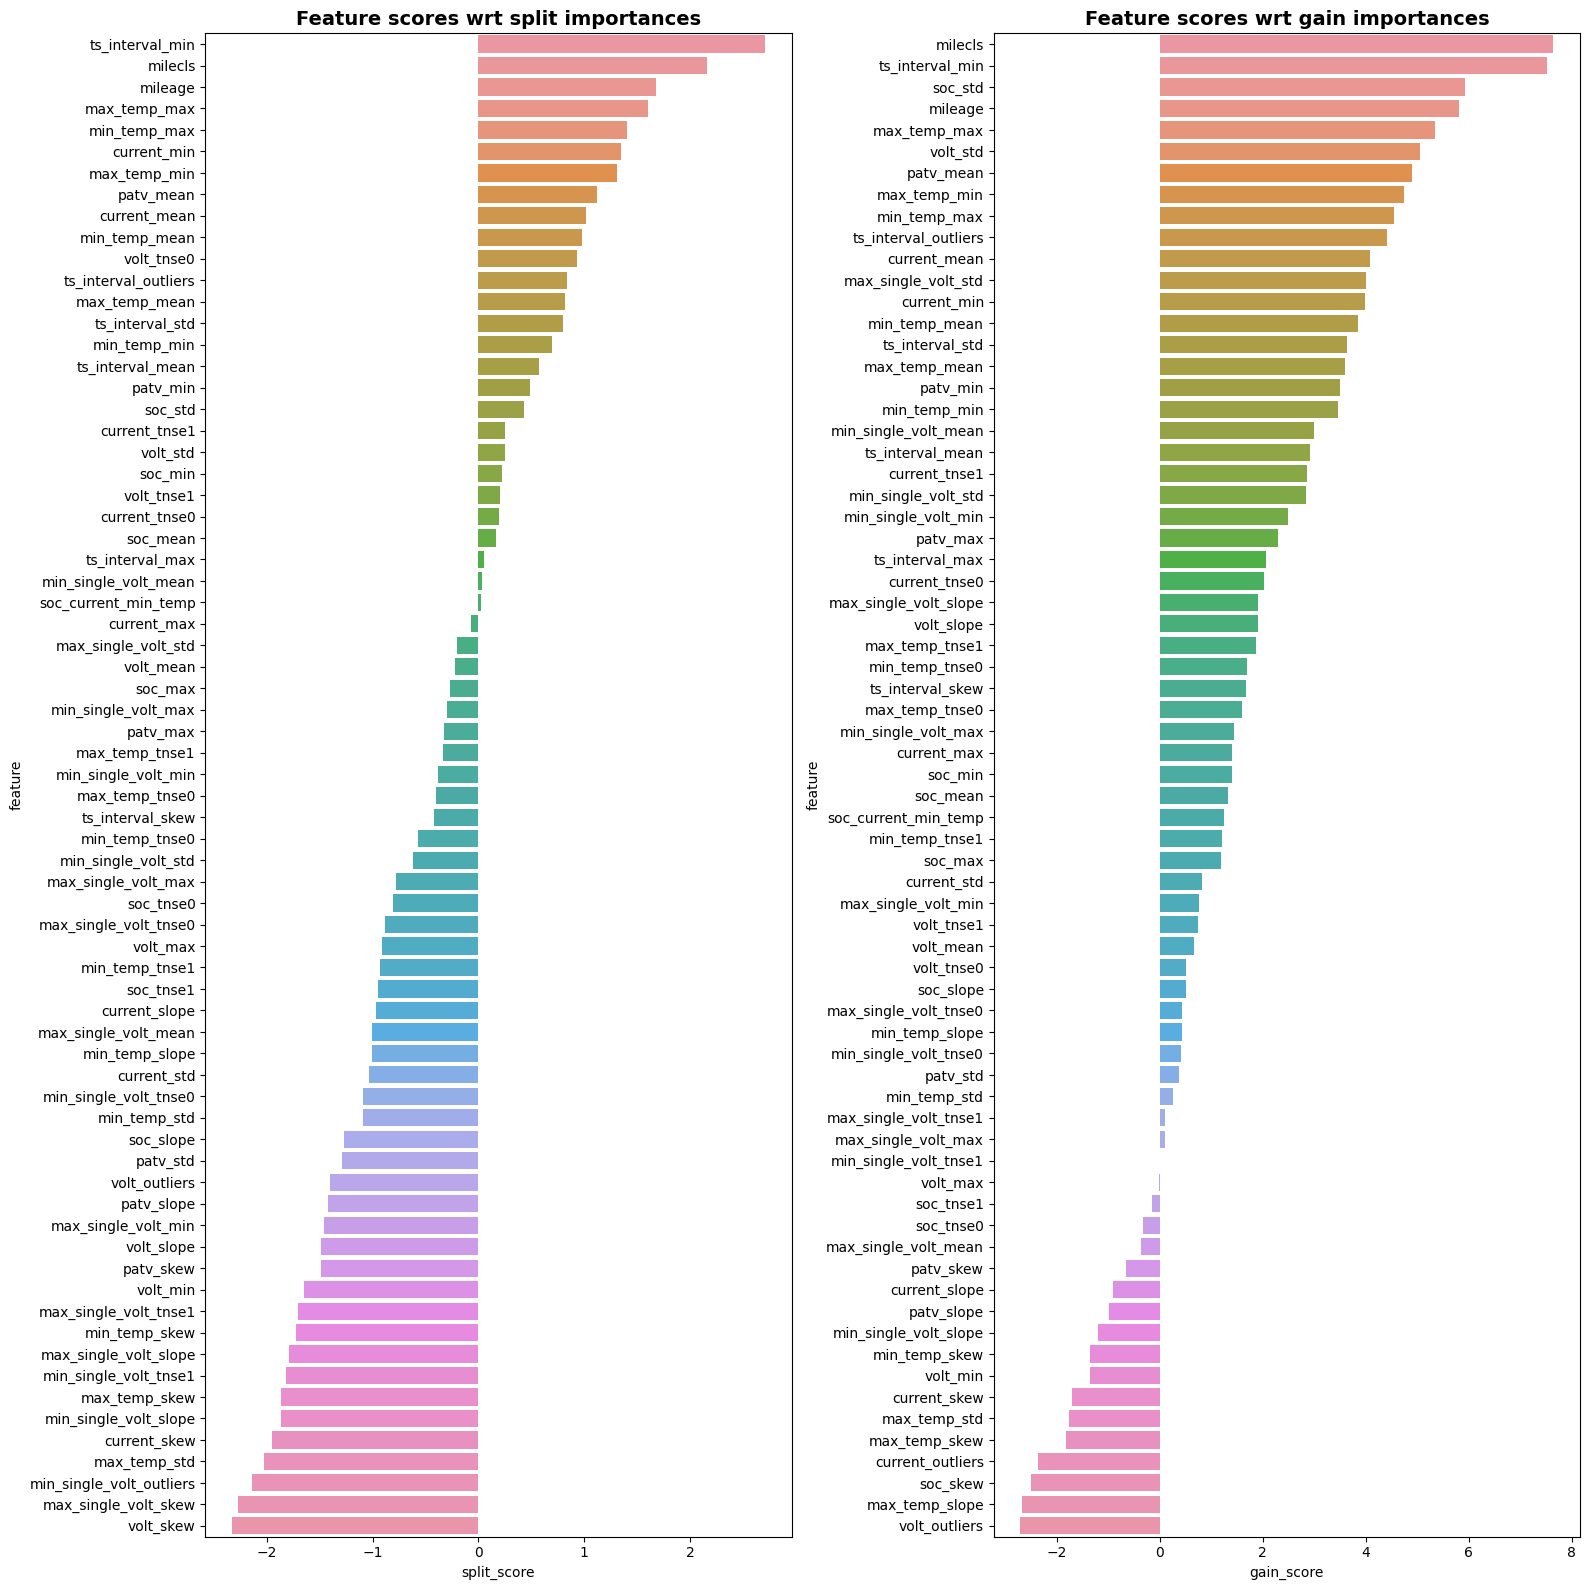

In [31]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [32]:
# null_imp_df.to_csv('null_importances_distribution_rf.csv')
# actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

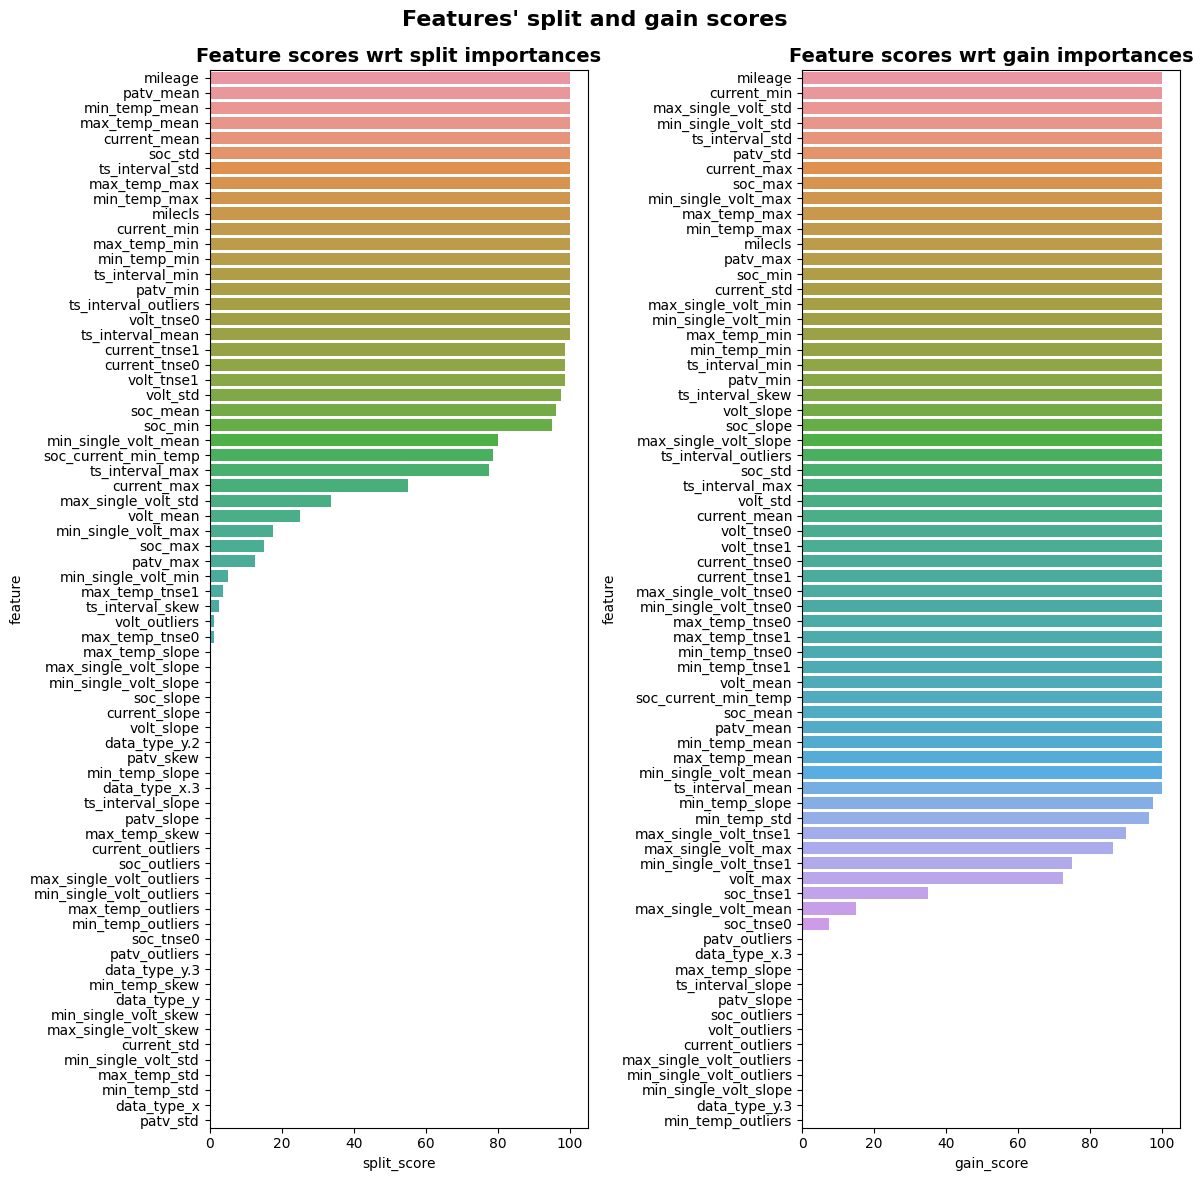

In [33]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [34]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
#     split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
#     split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
#     gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
#     gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
#     print('Results for threshold %3d' % threshold)
#     split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['label'])
#     print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
#     gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['label'])
#     print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

In [35]:
# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99, 99.9, 99.99]:
#     split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
#     split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
#     gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
#     gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
#     print(f'Results for threshold {threshold} ')
#     print(len(split_feats))
#     print(len(gain_feats))
#     print(len(set(gain_feats)&set(split_feats)))
for threshold in [0.1,10,30,60,80,95,99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print(f'Results for threshold {threshold} ')
    print(len(split_feats))
    print(len(gain_feats))
    print(len(set(gain_feats)&set(split_feats)))
    print(set(split_feats))
    print(set(gain_feats))
    print(set(gain_feats)&set(split_feats))



Results for threshold 0.1 
38
57
37
{'current_max', 'ts_interval_mean', 'ts_interval_outliers', 'max_single_volt_std', 'volt_tnse0', 'soc_current_min_temp', 'min_single_volt_mean', 'patv_min', 'volt_tnse1', 'ts_interval_min', 'max_temp_tnse1', 'current_tnse0', 'patv_mean', 'volt_outliers', 'soc_min', 'volt_mean', 'milecls', 'min_temp_max', 'current_tnse1', 'soc_max', 'patv_max', 'soc_mean', 'max_temp_tnse0', 'current_min', 'current_mean', 'max_temp_max', 'mileage', 'min_temp_mean', 'ts_interval_std', 'min_single_volt_max', 'ts_interval_max', 'volt_std', 'min_single_volt_min', 'max_temp_min', 'soc_std', 'ts_interval_skew', 'min_temp_min', 'max_temp_mean'}
{'min_single_volt_tnse1', 'current_max', 'ts_interval_mean', 'ts_interval_outliers', 'max_single_volt_std', 'volt_tnse0', 'soc_current_min_temp', 'max_single_volt_tnse1', 'min_single_volt_mean', 'patv_min', 'soc_slope', 'volt_tnse1', 'ts_interval_min', 'max_temp_tnse1', 'volt_max', 'current_tnse0', 'soc_tnse1', 'current_std', 'max_sing